По представленным в датасете данным проведите анализ результатов проведенного A/B-тестирования для сайта. Для этого:

1.	Проанализируйте: есть ли пользователи, которые попали в обе группы тестирования. Если да, то исключите их.
2.	Подумайте, как поступить с нулевыми значениями выручки. Нужно ли фильтровать данные? Или нулевые значения свидетельствуют об отсутствии изменений?
3.	Исключите дубли в записях для одного и того же пользователя.
4.	Проанализируйте выбросы в данных с помощью диаграммы размаха («ящика с усами»). Поработайте с ними, чтобы исключить вероятность их влияния на результаты тестирования.
5.	Проверьте распределение на нормальность, используя разные статистические тесты (например, Шапиро-Уилка). Если нужно, приведите данные к нормальному виду.
6.	Если удалось привести данные к нормальному виду при наименьшей потере данных, используйте параметрические тесты для А/В теста, предполагающие нормальность распределения. Если привести к нормальному виду не представляется возможным без большой потери данных, используйте непараметрические тесты (Манна-Уитни, Колмогорова-Смирнова и пр.), не предполагающие нормального распределения.
7.	Сделайте выводы по результатам A/B-тестирования. Визуализируйте распределение выручки для контрольной версии сайта (А) с его измененной версией (В).


### Обработка данных. Предварительный этап

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [3]:
df = pd.read_csv("AB_Test_Results.csv")

In [4]:
#выведите первые строки датасета
df.head()

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0


In [5]:
#выведите длину датасета
df.shape

(10000, 3)

In [6]:
#выведите описательные статистики по датасету
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
#удалите пользователей, которые есть в двух группах
#для этого через groupby посчитайте, сколько для каждого пользователя представлено групп (1 или 2)
data_2groups = df.groupby('USER_ID')['REVENUE'].nunique()
data_2groups.head
#найдем индексы тех, у кого более 1 группы
data_2groups = data_2groups[data_2groups > 1].index
data_2groups


Index([ 124,  169,  282,  403,  443,  487,  618,  701,  702,  708,  828,  831,
        839,  868, 1035, 1053, 1106, 1252, 1254, 1339, 1883, 1939, 2166, 2181,
       2182, 2252, 2364, 2489, 2529, 2767, 2881, 3028, 3198, 3326, 3331, 3566,
       3699, 3797, 4113, 4209, 4724, 4858, 4870, 4918, 5046, 5053, 5134, 5205,
       5270, 5461, 5597, 5769, 5845, 5900, 6207, 6214, 6271, 6391, 6429, 6430,
       6492, 6497, 6614, 6678, 6792, 7206, 7238, 7358, 7613, 7912, 7915, 7930,
       8020, 8175, 8471, 8479, 8536, 8583, 8700, 8863, 8886, 8920, 8927, 8984,
       9150, 9526, 9661, 9669, 9766, 9928, 9942, 9996],
      dtype='int64', name='USER_ID')

In [8]:
#очищаем от них датасет
df_clean = df[~df['USER_ID'].isin(data_2groups)]
df_clean

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [9]:
#очищаем дубликаты по датасету
df_clean.drop_duplicates(subset=['USER_ID'], inplace = True)
df_clean

C:\Users\tg082\AppData\Local\Temp\ipykernel_23596\3149705453.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop_duplicates(subset=['USER_ID'], inplace = True)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9988,428,control,0.0
9991,8864,variant,0.0
9996,502,variant,0.0
9998,7741,control,0.0


In [10]:
#выводим описательные статистики по новому датасету
df_clean.describe()

,USER_ID,REVENUE
count,6232.000000,6232.000000
mean,4985.166560,0.073310
std,2890.859828,2.569725
min,2.000000,0.000000
25%,2473.750000,0.000000
50%,4964.500000,0.000000
75%,7505.750000,0.000000
max,10000.000000,196.010000


In [11]:
#выведите длину датасета
df_clean.shape

(6232, 3)

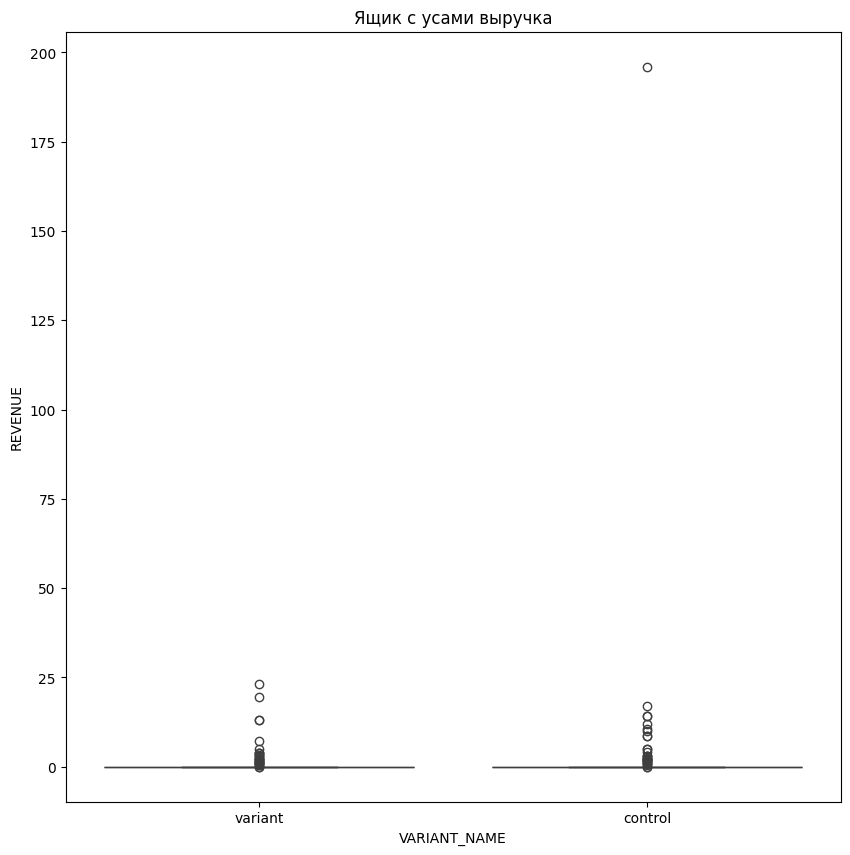

In [12]:
#строим график ящик с усами
plt.figure(figsize=(10, 10))
sns.boxplot(data = df_clean, x = 'VARIANT_NAME', y = 'REVENUE')
plt.title('Ящик с усами выручка')
plt.show()

In [13]:
#удаляем наиболее отдаленный выброс в 1 из групп
df_clean = df_clean[df_clean['REVENUE'] < 100]
df_clean.shape

(6231, 3)

In [14]:
#можно попробовать удалить по правилу трех сигм выбросы (опционально)
sigma = df_clean['REVENUE'].std() * 3
mean = df_clean['REVENUE'].mean()
df_clean_new = df_clean[(df_clean['REVENUE'] > (mean - sigma)) & (df_clean['REVENUE'] < (mean + sigma))]
display(df_clean_new.shape,
df_clean_new.describe())

(6197, 3)

,USER_ID,REVENUE
count,6197.000000,6197.000000
mean,4987.174923,0.003763
std,2890.878412,0.072052
min,2.000000,0.000000
25%,2477.000000,0.000000
50%,4965.000000,0.000000
75%,7511.000000,0.000000
max,10000.000000,2.020000


In [15]:
#проверяем на нормальность по каждой группе и в целом распределение выручки
print('=====ТЕСТ ШАПИРО-УИЛКА ДЛЯ ВСЕХ ДАННЫХ=====')
stat, p_value = stats.shapiro(df_clean_new['REVENUE'])
print(stat.round(4))
print(p_value)
print('=====ТЕСТ ШАПИРО-УИЛКА ДЛЯ VARIANT=====')
stat_v, p_value_v = stats.shapiro(df_clean_new[df_clean_new['VARIANT_NAME'] == 'variant']['REVENUE'])
print(stat_v.round(4))
print(p_value_v)
print('=====ТЕСТ ШАПИРО-УИЛКА ДЛЯ CONTROL=====')
stat_c, p_value_c = stats.shapiro(df_clean_new[df_clean_new['VARIANT_NAME'] == 'variant']['REVENUE'])
print(stat_c.round(4))
print(p_value_c)

=====ТЕСТ ШАПИРО-УИЛКА ДЛЯ ВСЕХ ДАННЫХ=====
0.0269
4.8900412062949283e-101
=====ТЕСТ ШАПИРО-УИЛКА ДЛЯ VARIANT=====
0.0284
4.3850797997255304e-83
=====ТЕСТ ШАПИРО-УИЛКА ДЛЯ CONTROL=====
0.0284
4.3850797997255304e-83


C:\Users\tg082\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6197.
  res = hypotest_fun_out(*samples, **kwds)


*Справочно: тест Шапиро-Уилка проверяет следующую гипотезу H0: данные распределены нормально; H1: данные НЕ распределены нормально. Если p-value выше заданного уровня значимости, то H0 не отвергается.

### Вариант 1. Не удаляем нули по выручке

In [16]:
#применение непараметрических/параметрических тестов(?)


Непараметрические тесты: когда распределение не нормально

In [17]:
#тест Манна-Уитни
variant = df_clean_new[df_clean_new['VARIANT_NAME'] == 'variant']['REVENUE']
control = df_clean_new[df_clean_new['VARIANT_NAME'] == 'control']['REVENUE']
statistic, p_value = stats.mannwhitneyu(variant, control, alternative='two-sided')
print('=====ТЕСТ МАННА-УИТНИ=====')
print(statistic)
print(p_value)

=====ТЕСТ МАННА-УИТНИ=====
4800656.5
0.8836827899906813


In [18]:
#тест Колмогорова-Смирнова
ks_statistic, ks_pvalue = stats.ks_2samp(variant, control)
print('=====тест Колмогорова-Смирнова=====')
print(f'Статистика: {ks_statistic}')
print(f'P-value: {ks_pvalue}')
print(f'Есть статистически значимые различия: {ks_pvalue < 0.05}')

=====тест Колмогорова-Смирнова=====
Статистика: 0.0009889425534073775
P-value: 1.0
Есть статистически значимые различия: False


In [19]:
#попробуйте найти еще тесты...
# Тест Краскела-Уоллиса
from scipy.stats import kruskal
h_stat, h_pvalue = kruskal(variant, control)
print(f'Тест Краскела-Уоллиса:')
print(f'Статистика: {h_stat.round(4)}')
print(f'P-value: {h_pvalue}')
print(f'Есть статистически значимые различия: {h_pvalue < 0.05}')

Тест Краскела-Уоллиса:
Статистика: 0.0214
P-value: 0.883629569040786
Есть статистически значимые различия: False


Параметрические тесты: требуют нормальности распределения

In [20]:
# Двусторонний t-тест Стьюдента
t_stat, p_value = stats.ttest_ind(variant, control)


In [21]:
# равенство дисперсий (тест Левена)
levene_stat, levene_p = stats.levene(variant, control)


In [22]:
#попробуйте найти еще тесты...

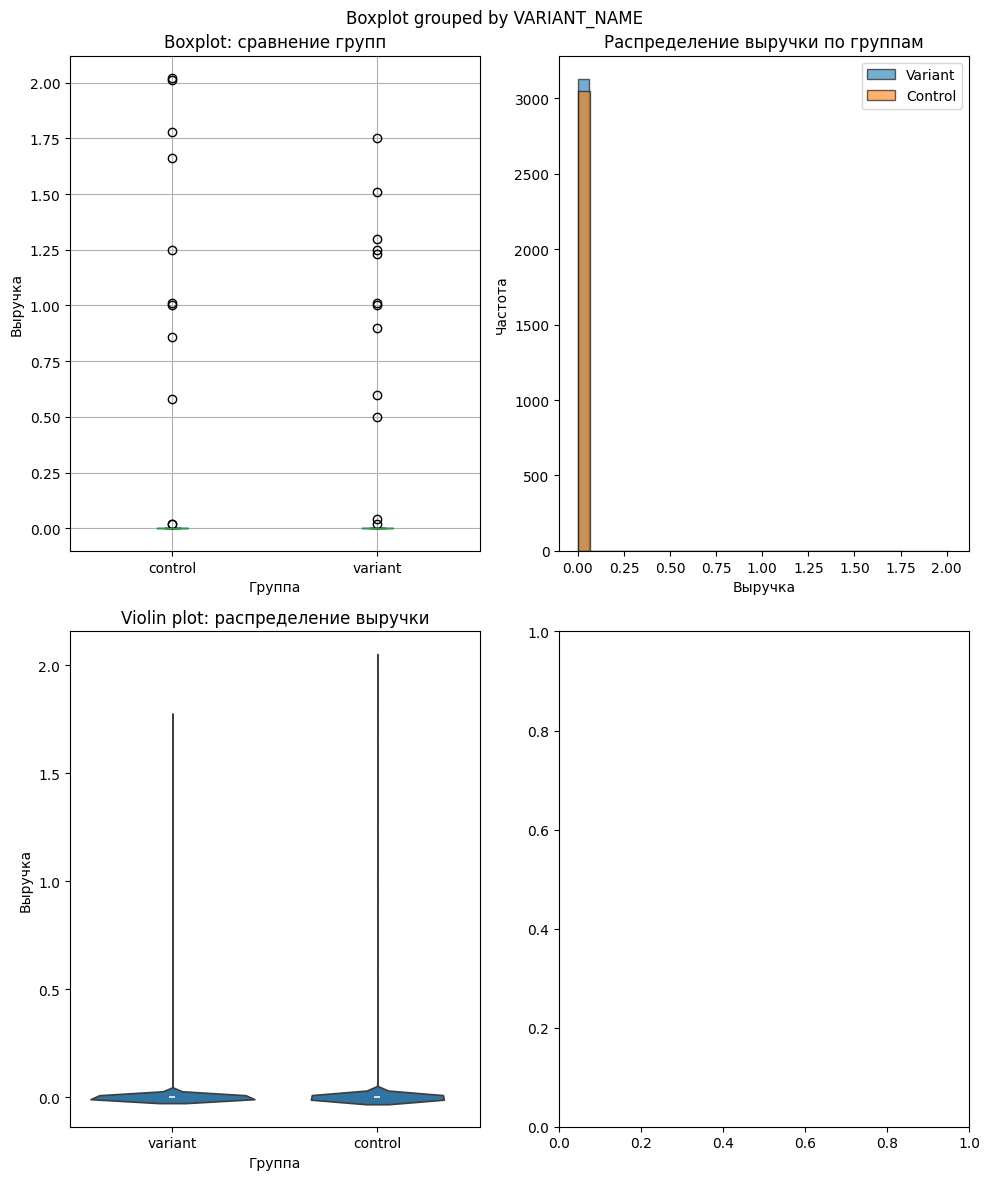

In [23]:
#визуализация
fig, axes = plt.subplots(2, 2, figsize=(10, 12))

# Boxplot
df_clean_new.boxplot(column='REVENUE', by='VARIANT_NAME', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot: сравнение групп')
axes[0, 0].set_xlabel('Группа')
axes[0, 0].set_ylabel('Выручка')
plt.sca(axes[0, 0])
plt.xticks(rotation=0)

# Гистограммы
axes[0, 1].hist(variant, alpha=0.6, label='Variant', bins=30, edgecolor='black')
axes[0, 1].hist(control, alpha=0.6, label='Control', bins=30, edgecolor='black')
axes[0, 1].set_title('Распределение выручки по группам')
axes[0, 1].set_xlabel('Выручка')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].legend()

# Violin plot
sns.violinplot(data=df_clean_new, x='VARIANT_NAME', y='REVENUE', ax=axes[1, 0])
axes[1, 0].set_title('Violin plot: распределение выручки')
axes[1, 0].set_xlabel('Группа')
axes[1, 0].set_ylabel('Выручка')

plt.tight_layout()
plt.show()

### Вариант 2. Удаляем нули по выручке

In [24]:
# то же самое, в случае нормальности - одно, в случае если данные не нормальны - другое
# Удаляем нули
df_no_zero = df_clean_new[df_clean_new['REVENUE'] > 0]
print(f'Размер данных без нулей: {df_no_zero.shape}')
print(f'Удалено записей с нулевой выручкой: {len(df_clean_new) - len(df_no_zero)}')

Размер данных без нулей: (23, 3)
Удалено записей с нулевой выручкой: 6174


### Проверка на нормальность без нулей

In [25]:
print('\n=====ПРОВЕРКА НА НОРМАЛЬНОСТЬ (БЕЗ НУЛЕЙ)=====')
variant_no_zero = df_no_zero[df_no_zero['VARIANT_NAME'] == 'variant']['REVENUE']
control_no_zero = df_no_zero[df_no_zero['VARIANT_NAME'] == 'control']['REVENUE']

stat_v2, p_value_v2 = stats.shapiro(variant_no_zero)
print('\nVARIANT:')
print(f' p-value: {p_value_v2.round(5)}')
print(f'Нормальное распределение: {p_value_v2 > 0.05}')

print('\nCONTROL:')
stat_c2, p_value_c2 = stats.shapiro(control_no_zero)
print(f'Shapiro-Wilk p-value: {p_value_c2.round(5)}')
print(f'Нормальное распределение: {p_value_c2 > 0.05}')


=====ПРОВЕРКА НА НОРМАЛЬНОСТЬ (БЕЗ НУЛЕЙ)=====

VARIANT:
 p-value: 0.58582
Нормальное распределение: True

CONTROL:
Shapiro-Wilk p-value: 0.36445
Нормальное распределение: True


### Применяем тесты

In [26]:
print('\n=====НЕПАРАМЕТРИЧЕСКИЕ ТЕСТЫ (БЕЗ НУЛЕЙ)=====')
mann_stat2, mann_p2 = stats.mannwhitneyu(variant_no_zero, control_no_zero, alternative='two-sided')
print(f'Манн-Уитни p-value: {mann_p2:.6f}')
print(f'Различия значимы: {mann_p2 < 0.05}')

ks_stat2, ks_p2 = stats.ks_2samp(variant_no_zero, control_no_zero)
print(f'Колмогоров-Смирнов p-value: {ks_p2:.6f}')
print(f'Различия значимы: {ks_p2 < 0.05}')


=====НЕПАРАМЕТРИЧЕСКИЕ ТЕСТЫ (БЕЗ НУЛЕЙ)=====
Манн-Уитни p-value: 0.578982
Различия значимы: False
Колмогоров-Смирнов p-value: 0.667507
Различия значимы: False


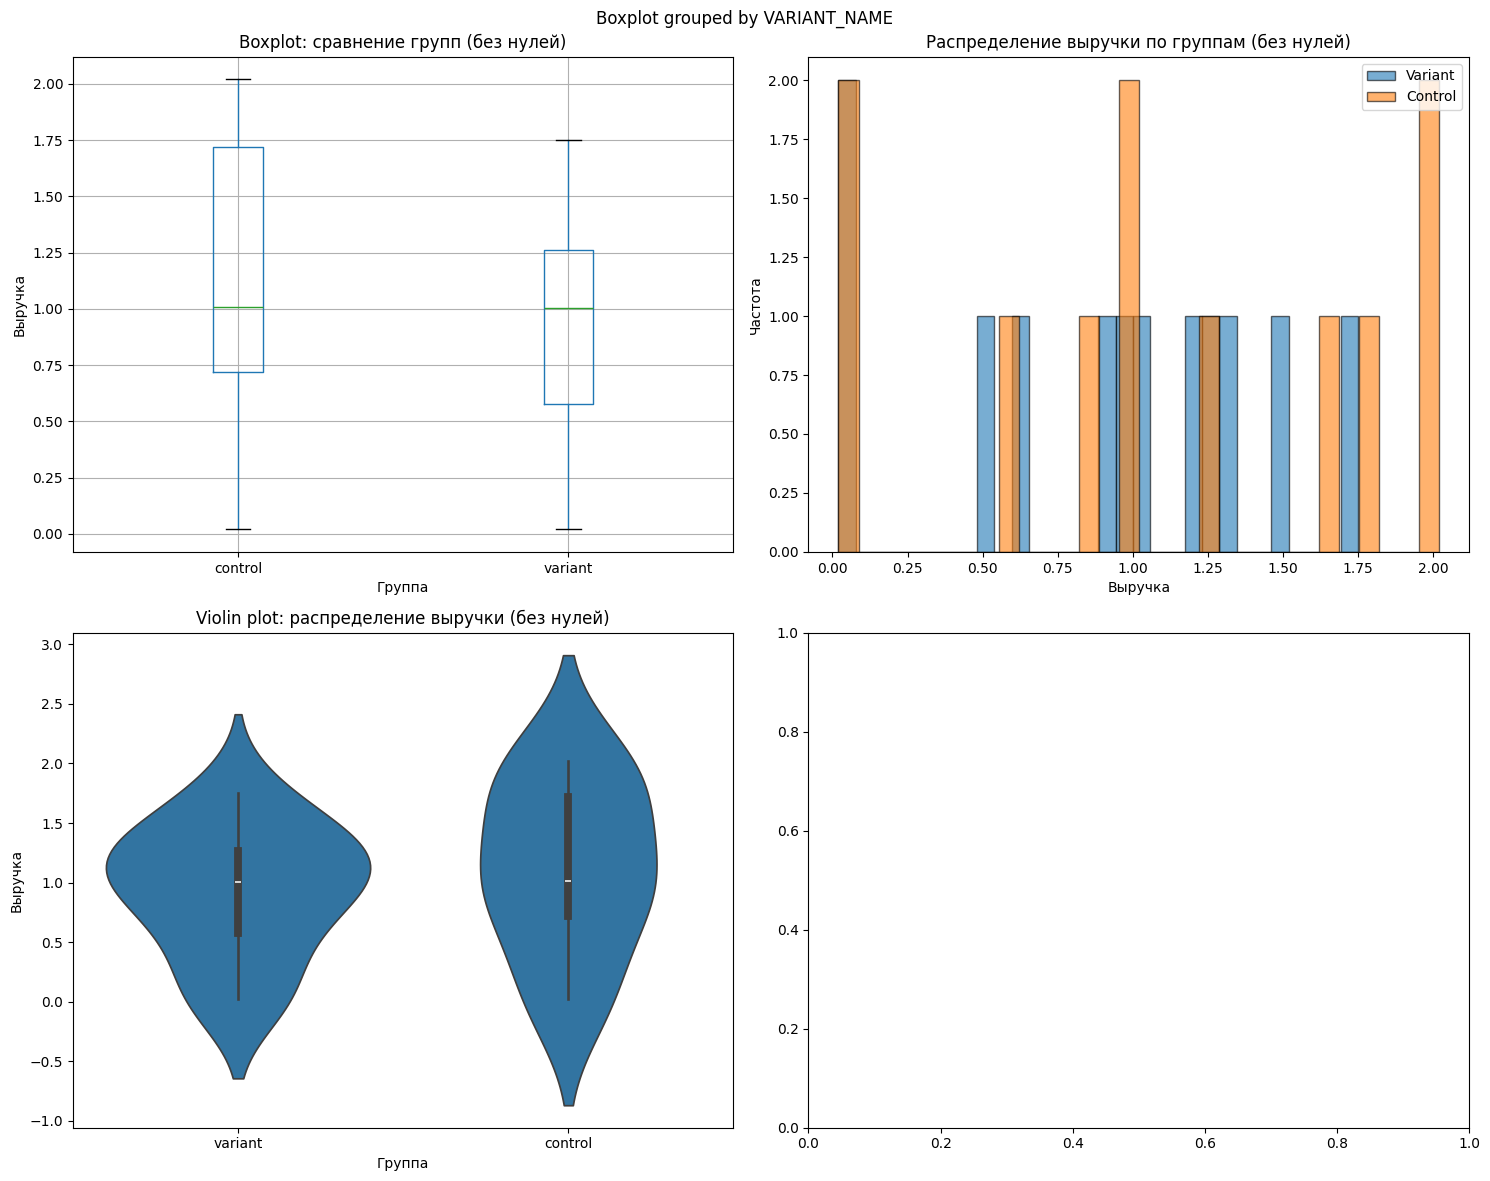

In [27]:
#визуализация
#визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot
df_no_zero.boxplot(column='REVENUE', by='VARIANT_NAME', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot: сравнение групп (без нулей)')
axes[0, 0].set_xlabel('Группа')
axes[0, 0].set_ylabel('Выручка')
plt.sca(axes[0, 0])

# Гистограммы
axes[0, 1].hist(variant_no_zero, alpha=0.6, label='Variant', bins=30, edgecolor='black')
axes[0, 1].hist(control_no_zero, alpha=0.6, label='Control', bins=30, edgecolor='black')
axes[0, 1].set_title('Распределение выручки по группам (без нулей)')
axes[0, 1].set_xlabel('Выручка')
axes[0, 1].set_ylabel('Частота')
axes[0, 1].legend()

# Violin plot
sns.violinplot(data=df_no_zero, x='VARIANT_NAME', y='REVENUE', ax=axes[1, 0])
axes[1, 0].set_title('Violin plot: распределение выручки (без нулей)')
axes[1, 0].set_xlabel('Группа')
axes[1, 0].set_ylabel('Выручка')

plt.tight_layout()
plt.show()

In [28]:
display(variant_no_zero.count(), variant_no_zero.mean(),
control_no_zero.count())


np.int64(12)

np.float64(0.9258333333333333)

np.int64(11)

### Выводы:

До того, как мы убрали нули из распределения было ничего не понятно из-за их большого количества (примерно 99% от всех данных), после удаления нулей стало ясно, что вариант B не поменялось особо, распределение стало более растянутым и медиана не так выражена теперь.